# Wannierization

Electronic simulation codes like Quantum Espresso calculate the Bloch bands $\varepsilon_{\mathbf kn}$ and wavefunctions $\psi_{n\mathbf k}(\mathbf r)$ of a crystal lattice. These bands are gauge invariant while the wavefunctions allow for an ambiguity in the choice of complex phase. These gauges need to be consistent if we wish to transform these wavefunctions to a localized Wannier function {cite}`wannier_review`:

$$
|\mathbf Rn\rangle=\frac{V}{(2\pi)^2}\int_{BZ}\text d\mathbf k\, \text e^{-i\mathbf k\cdot\mathbf R}|\psi_{n\mathbf k}\rangle.
$$(eq:wannier_transform)

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from myst_nb import glue
from scipy import integrate
import matplotlib.pyplot as plt
import pandas as pd
from moire.plot import figure

## Projection method

One way to remove the gauge inconsistency is to project trial orbitals $|g_n\rangle$ on the basis of the Bloch wavefunctions:

$$
|\phi_{n\mathbf k}\rangle=\underbrace{\sum_m|\psi_{m\mathbf k}\rangle\langle\psi_{m\mathbf k}}_{P_\mathbf k}|g_{n}\rangle.
$$(eq:nonorthogonal)

The projector $P_\mathbf k$ is gauge invariant so the $|\phi_{n\mathbf k}\rangle$ are as well. The $|\phi_{n\mathbf k}\rangle$ are however not necessarily orthogonal. In general we have:

$$
\mathbf S_{mn,\mathbf k} = \langle\phi_{m\mathbf k}|\phi_{n\mathbf k}\rangle\neq\delta_{mn}
$$(eq:Smnk)

Marzari et al. {cite}`wannier_review` propose to orthogonalize the states using a Löwdin transform which finds a set of orthonormal basis functions $|\tilde\psi_{n\mathbf k}\rangle$ that minimizes:

$$
\sum_n \int\text d \mathbf x\,\left |\phi_{n\mathbf k}(\mathbf x)-\tilde\psi_{n\mathbf k}(\mathbf x)\right|^2,
$$(eq:iafbaeifbfaew)

which corresponds to taking:

$$
|\tilde\psi_{n\mathbf k}\rangle=\sum_m|\phi_{m\mathbf k}\rangle \left(\mathbf S_\mathbf k^{-1/2}\right)_{mn}.
$$(eq:tildepsi)

### Example: 1 band

We illustrate the projection method using an example of a 1d isolated band with mock Bloch wavefunction $\psi_\mathbf k(\mathbf r)=u_\mathbf k(\mathbf r)\text e^{i\mathbf k\cdot\mathbf r}$. This functions must obey the periodicity requirements:

* $\psi_{\mathbf k+\mathbf G}(\mathbf r)=\psi_{\mathbf k}(\mathbf r)$, with $\mathbf G$ a reciprocal lattice vector $\rightarrow u_{\mathbf k+\mathbf G}(\mathbf r)=\text e^{-i\mathbf G\cdot\mathbf r}u_{\mathbf k}(\mathbf r)$.
* $u_\mathbf k(\mathbf r+\mathbf T)=u_\mathbf k(\mathbf r)$, with $\mathbf T$ a lattice vector.

Since $u_\mathbf k(\mathbf r)$ is periodic in real space we can express it as a Fourier series:

$$
u_\mathbf k(\mathbf r)=\sum_\mathbf G C_{\mathbf G+\mathbf k}\text e^{i\mathbf G\cdot r} 
$$(eq:u_transform)

with the $C_{\mathbf G+\mathbf k}$ some Fourier components and the sum over all reciprocal lattice vectors. We show that this choice complies with the periodicity of the Bloch function in $\mathbf k$ space:

$$
u_{\mathbf k+\mathbf G'}(\mathbf r)=\sum_\mathbf G C_{\mathbf G+\mathbf G'+\mathbf k}\text e^{i\mathbf G\cdot r} =\sum_\mathbf {\tilde G}C_{\mathbf {\tilde G}+\mathbf k}\text e^{i(\mathbf {\tilde G}-\mathbf G')\cdot r}=\text e^{-i\mathbf G'\cdot r}\sum_\mathbf {\tilde G}C_{\mathbf {\tilde G}+\mathbf k}\text e^{i\mathbf {\tilde G}\cdot r}=\text e^{-i\mathbf G'\cdot r}u_{\mathbf k}(\mathbf r)
$$(hjavvsvzd a)

Now we plug this form of $u$ in equation `numref`{eq:wannier_transform} to get the Wannier function for $R=0$:

$$
w_0(\mathbf r)\propto\int_{BZ}\text d\mathbf k\, \text e^{i\mathbf k\cdot\mathbf r}\sum_\mathbf G C_{\mathbf G+\mathbf k}\text e^{i\mathbf G\cdot r} 
=\sum_\mathbf G\int_{BZ}\text d\mathbf k\, C_{\mathbf G+\mathbf k}\text e^{i(\mathbf G+\mathbf k)\cdot r}=\int\text d\mathbf k\, C_{\mathbf k}\text e^{i\mathbf k\cdot r},
$$(iophseocbpnb)

where the last integral is over all $\mathbf k$ space.

This description makes clear that $C_k$ needs to have power law or Gaussian decay to acquire exponentially localized Wannier functions. If we neglect this condition the according Bloch waves become highly irregular and oscillate wildly in the unit cell.

For this example we choose:

$$
C_\mathbf k = \text e^{-k^2/100}\cos(k/3.4),
$$

which leads to the following Bloch function:

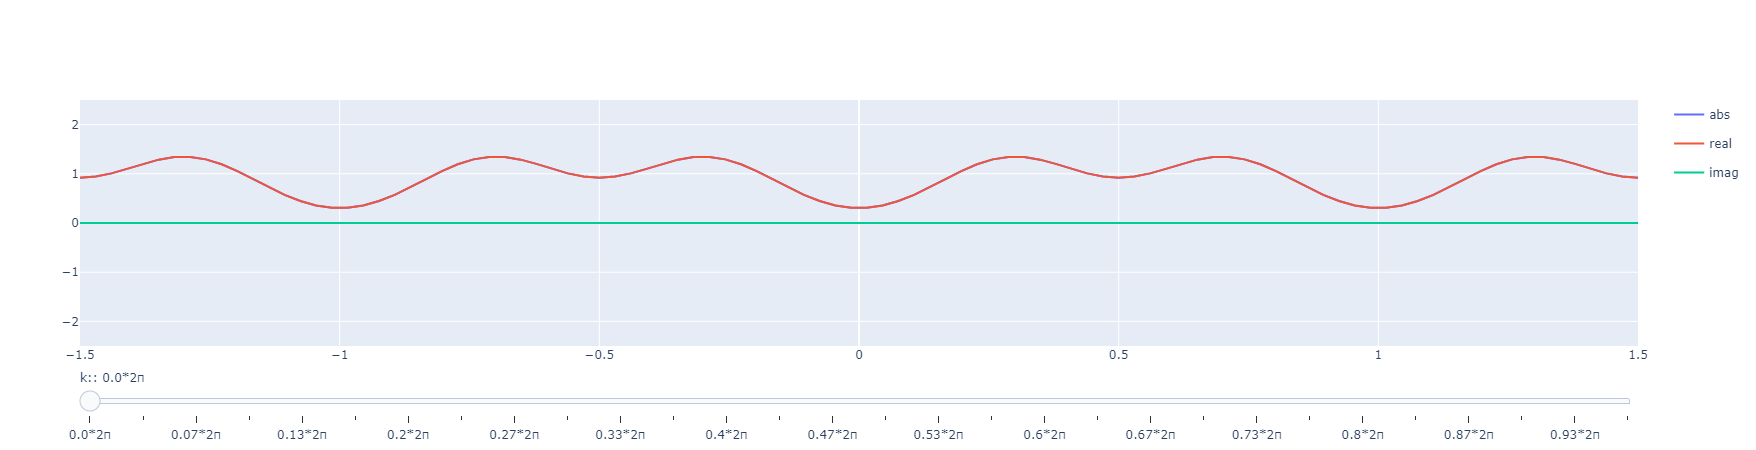

In [14]:
N_x = 100
N_k = 30
c = 3

def u(x, k):
    N = 15
    C = lambda k: np.exp(-k**2/100) * np.cos(k/3.4)
    x, G = np.meshgrid(x, 2*np.pi*np.arange(-N, N+1))
    return np.sum(C(k+G)*np.exp(1j*G*x), axis=0)

norms = np.sqrt([np.sum(np.abs(u(x_mesh, k))**2)/N_x for k in k_mesh])

def bloch(x, j):
    k = 2*np.pi*j/N_k
    return u(x, k) * np.exp(1j*x*k) / norms[int(j%N_k)]

@figure
def plot_bloch(x=0, i=0, f=lambda x: x, **kwargs):
    y = bloch(x, i)
    return [go.Scatter(visible=False, x=x, y=f(y))]

legend=dict(args=dict(f=[np.abs, np.real, np.imag]), tags=['abs', 'real', 'imag'], auto_color=True) 
slider=dict(args=dict(i=range(N_k)), tags=[str(round(j/N_k, 2))+"*2π" for j in range(N_k)], prefix='k:')

plot = plot_bloch(x=c*np.linspace(-0.5, 0.5, N_x), legend=legend, slider=slider)
plot.update_layout(yaxis=dict(range=[-2.5, 2.5]))
plot.show()

We note that the real part of $\psi_k(x)$ is symmetric while the imaginary part is antisymmetric. Any symmetric $g$ will then have a purely real overlap wth $\psi$. For this function we choose a Gaussian:

$$
g(x)=\text e^{-x^2}.
$$(wvtwggvbvzsd)

Any normalization of $g$ and $\psi$ will cancel in the construction of the orthonormal $\tilde\psi$. We now do the inverse transform of the Bloch wavefunctions of `ref`{eq:wannier_transform} do get the following localized Wannier function:

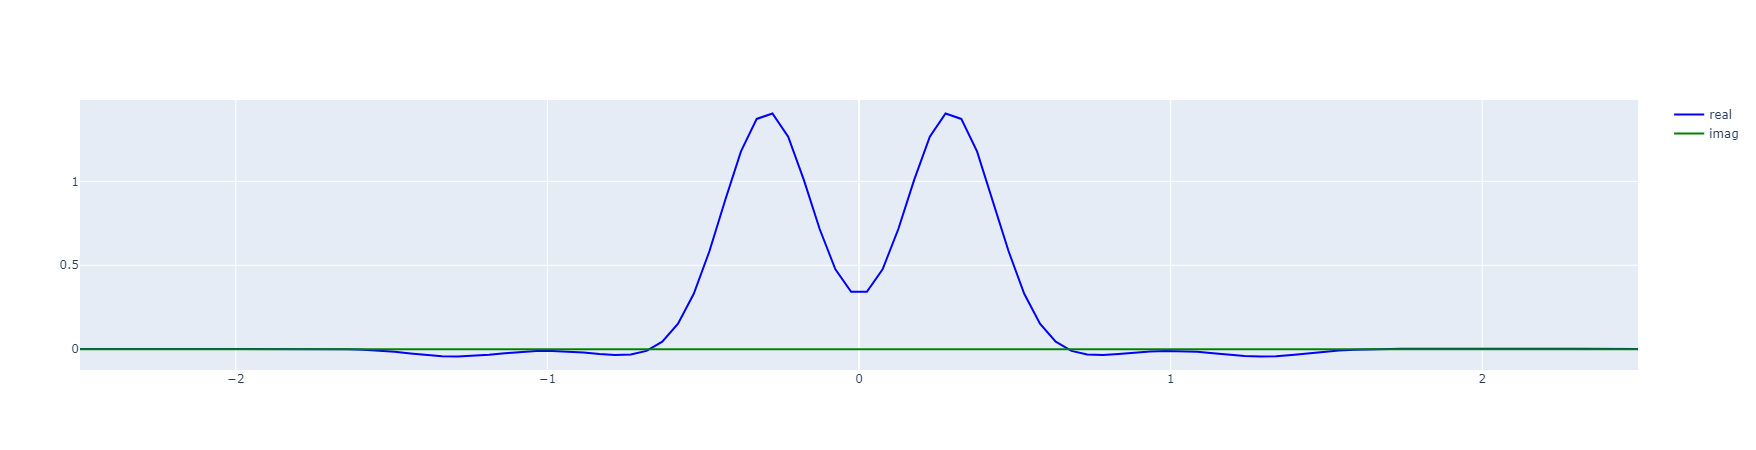

In [3]:
def g(x):
    return np.exp(-x**2*6)

g_k = np.zeros(N_k, dtype=complex)
for j in range(N_k):
    g_k[j] = np.sum(g(x_mesh)*bloch(x_mesh, j))

c = 5
y = np.sum([(g_k[step]/ np.abs(g_k[step]+0.00001)* np.conj(bloch(c*x_mesh, step))) for step in range(N_k)], axis=0)
my_y = y / np.sqrt(c/N_x*np.sum(np.abs(y)**2))

fig = go.Figure()
fig.add_trace(
        go.Scatter(
            name="real",
            x=c*x_mesh,
            line = dict(color='blue'),
            y=np.real(my_y)))
fig.add_trace(
        go.Scatter(
            name="imag",
            line = dict(color='green'),
            x=c*x_mesh,
            y=np.imag(my_y)))
fig.show()

```{glue:figure} fig:basis_functions
Three periodic $u_i(\mathbf r)$ in a triangular lattice based on sp$^2$ orbitals. We aim to construct localized Wannier orbitals using the three standard atomic orbitals: s, p$_x$ and p$_y$ 
```

We see that the Wannier function is exponentially localized around $x=0$ with local maxima (minima) appearing around $x\in \mathbb Z$ which become exponentially smaller for larger $x$.

### Example: 2d atomic orbitals as Bloch wavefunction

To make matters a bit more interesting we'll look at the hibridization of the s, p_$x$ and p$_y$ orbitals in a triangular lattice. As $u$ component of the Bloch waves we take the three sp$^2$ orbitals which we label with $\gamma_m$ and as $g_n$ we take the normal orbitals. We take the $C_{i\mathbf k}$ to be the inverse Fourier transforms of the $\gamma_m$:

$$
C_{m\mathbf k}\propto\int\textbf d\mathbf r\,\gamma_m(\mathbf r)\text e^{-i\textbf r\cdot k},
$$(bbdaaibwd)

which we then plug in equation `numref`{eq:u_transform}:

$$
\begin{align}
u_{m\mathbf k}(\mathbf r)&\propto\sum_\mathbf G\text e^{i\mathbf G\cdot r}\int\textbf d\mathbf {r}'\,\gamma_m(\mathbf{r}')\text e^{-i\mathbf{r}'\cdot (\mathbf G+\mathbf k)}\\
&=\int\textbf d\mathbf {r}'\,\gamma_m(\mathbf{r}')\text e^{-i\mathbf{r}'\cdot\mathbf k}\sum_\mathbf G\text e^{i\mathbf G\cdot (\mathbf r - \mathbf{r}')}\\
&=\int\textbf d\mathbf {r}'\,\gamma_m(\mathbf{r}')\text e^{-i\mathbf{r}'\cdot\mathbf k}\sum_\mathbf R\delta(\mathbf R+\mathbf r - \mathbf{r}')\\
&=\sum_\mathbf R\gamma_m(\mathbf{r}+\mathbf R)\text e^{-i(\mathbf{r}+\mathbf R)\cdot\mathbf k},
\end{align}
$$(jipibscp sbip)

or:

$$
\psi_{m\mathbf k}(\mathbf r)=\frac1\Omega\sum_\mathbf R\gamma_m(\mathbf{r}+\mathbf R)\text e^{-i\mathbf R\cdot\mathbf k}.
$$(kbbasi efci)

with $\Omega$ a normalization constant, where we follow the normalization convention of `cite`{wannier_review}:

$$
\begin{align}
\frac{4\pi^2}{V}=\langle \psi_{m\mathbf k}|\psi_{m\mathbf k}\rangle &= \frac1{\Omega^2}\frac1N\sum_{\mathbf R\mathbf R'}\text e^{i(\mathbf R-\mathbf R')\cdot\mathbf k}\int\text d\mathbf r\,\gamma_m(\mathbf{r}+\mathbf R)\cdot\gamma_m(\mathbf{r}+\mathbf R')\\
&=\frac1{\Omega^2}\sum_{\mathbf R}\text e^{i\mathbf R\cdot\mathbf k}\int\text d\mathbf r\,\gamma_m(\mathbf{r}+\mathbf R)\cdot\gamma_m(\mathbf{r})\\
&=\frac1{\Omega^2}\int\text d\mathbf r\,\gamma_m(\mathbf{r})^2\\
&=\frac1{\Omega^2}
\end{align}
$$(kbibi)

where the factor N is the amount of unit cells in the lattice which cancels with one of the summations. Summations over nonzero $\mathbf R$ cancel due to lattice symmetry.

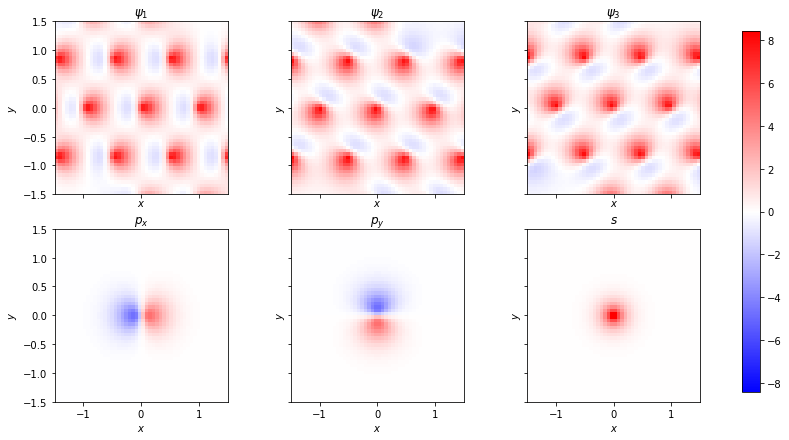

In [4]:
def p_rot(x, y, θ):
    R = np.array([[np.cos(θ),  np.sin(θ)],
                      [-np.sin(θ), np.cos(θ)]])
    return p_x(*np.tensordot(R, np.array([x, y]), axes=(1, 0)))
    
def p_x(x, y):
    return x*np.exp(-np.sqrt(x**2+y**2)*7)

def p_y(x, y):
    return y*np.exp(-np.sqrt(x**2+y**2)*7)

def s(x, y):
    return np.exp(-np.sqrt(x**2+y**2)*7)

L = 1.5
N = 50
mesh_tile = (L/N)**2
x_mesh, y_mesh = np.meshgrid(np.linspace(-L, L, N), np.linspace(-L, L, N))
k_x_mesh, k_y_mesh = np.meshgrid(np.linspace(-np.pi, np.pi, N), np.linspace(-np.pi, np.pi, N))

p_x_ = p_x(x_mesh, y_mesh)
p_y_ = p_y(x_mesh, y_mesh)
s_ = s(x_mesh, y_mesh)

p_norm = np.sqrt(np.sum(p_x_**2)*mesh_tile)
s_norm = np.sqrt(np.sum(s_**2)*mesh_tile)
p_x_ = p_x_ / p_norm
p_y_ = p_y_ / p_norm
s_ = s_ / s_norm

a_1 = np.array([1, 0])
a_2 = np.array([1/2, np.sqrt(3)/2])
R_list = [(1, 0), (0, 1), (1, -1), (2, 0), (2, 0), (1, 1), (2, -1), (-1, 2), (0, 2)]
R_list = [σ*(R[0]*a_1+R[1]*a_2) for R in R_list for σ in [-1, 1]] + [np.zeros(2)]

def γ_1(x, y):
    return (s(x, y)/s_norm + p_x(x, y)/p_norm) / np.sqrt(2)

def γ_2(x, y):
    return (s(x, y)/s_norm + p_rot(x, y, np.pi*2/3)/p_norm) / np.sqrt(2)


def γ_3(x, y):
    return (s(x, y)/s_norm + p_rot(x, y, -np.pi*2/3)/p_norm) / np.sqrt(2)

def ψ(x, y, k_x, k_y, γ):
    my_sum = 0
    for R in R_list:
        my_sum += γ(x+R[0], y+R[1]) * np.exp(-1j*(R[0]*k_x+R[1]*k_y))
    return my_sum
    
ψ_1 = ψ(x_mesh, y_mesh, 0, 0, γ_1)
ψ_2 = ψ(x_mesh, y_mesh, 0, 0, γ_2)
ψ_3 = ψ(x_mesh, y_mesh, 0, 0, γ_3)

my_max = np.max(s_)
my_range = dict(vmin=-my_max, vmax=my_max, cmap="bwr", extent=[-L,L,-L,L])


fig, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(15,7))
f =[[ψ_1, ψ_2, ψ_3], [p_x_, p_y_, s_]]
f_name = [[r"$\psi_1$", r"$\psi_2$", r"$\psi_3$"], [r"$p_x$", r"$p_y$", r"$s$"]]
for i in range(2):
    for j in range(3):
        im = axes[i, j].imshow(np.real(f[i][j]), **my_range)
        axes[i, j].title.set_text(f_name[i][j])
        axes[i, j].set_xlabel(r"$x$")
        axes[i, j].set_ylabel(r"$y$")
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
glue("fig:basis_functions", fig, display=False)

```{glue:figure} fig:basis_functions
Three periodic $u_i(\mathbf r)$ in a triangular lattice based on sp$^2$ orbitals. We aim to construct localized Wannier orbitals using the three standard atomic orbitals: s, p$_x$ and p$_y$ 
```

We write `ref`{eq:nonorthogonal} out in matrix form:

$$
\begin{pmatrix}
    |\phi_{1\mathbf k}\rangle\\
    |\phi_{2\mathbf k}\rangle\\
    |\phi_{3\mathbf k}\rangle\\
\end{pmatrix}=\underbrace{
\begin{pmatrix}
    \langle \psi_{1\mathbf k}|g_{1}\rangle  & \langle  \psi_{2\mathbf k}|g_{1}\rangle &\langle  \psi_{3\mathbf k}|g_{1}\rangle\\
        \langle  \psi_{1\mathbf k}|g_{2}\rangle  & \langle  \psi_{2\mathbf k}|g_{2}\rangle &\langle  \psi_{3\mathbf k}|g_{2}\rangle\\
        \langle  \psi_{1\mathbf k}|g_{3}\rangle  & \langle  \psi_{2\mathbf k}|g_{3}\rangle &\langle  \psi_{3\mathbf k}|g_{3}\rangle\\
\end{pmatrix}}_{A_\mathbf k}
\begin{pmatrix}
    |  \psi_{1\mathbf k}\rangle\\
    |  \psi_{2\mathbf k}\rangle\\
    |  \psi_{3\mathbf k}\rangle\\
\end{pmatrix},
$$

then $S_\mathbf k=A_\mathbf k^\dagger A_\mathbf k$, which we diagonalize: $S_\mathbf k=U_\mathbf k^\dagger S^d_\mathbf k U_\mathbf k$. Now we get: $S_\mathbf k^{-1/2}=U_\mathbf k \left(S^d_\mathbf k\right)^{-1/2} U_\mathbf k^\dagger$ and $S_\mathbf k^{-1/2}A_\mathbf k$ is the rotation matrix for the Bloch functions. We remind that any normalization of $g_i$ cancels in this product.

The components of $A_\mathbf k $ can be simplified analytically:

$$
\begin{align}
\langle \psi_{m\mathbf k}|g_n\rangle&=\int\text d\mathbf r\sum_\mathbf R\gamma_m(\mathbf{r}+\mathbf R)\text e^{i\mathbf R\cdot\mathbf k}g_n(\mathbf r)\\
&=\sum_\mathbf R\text e^{i\mathbf R\cdot\mathbf k}\int\text d\mathbf r\,\gamma_m(\mathbf{r}+\mathbf R)g_n(\mathbf r),
\end{align}
$$

where the integral does no longer depend on $\mathbf k$. We compute this integral using sums over coordinate meshes to speed up calculations.

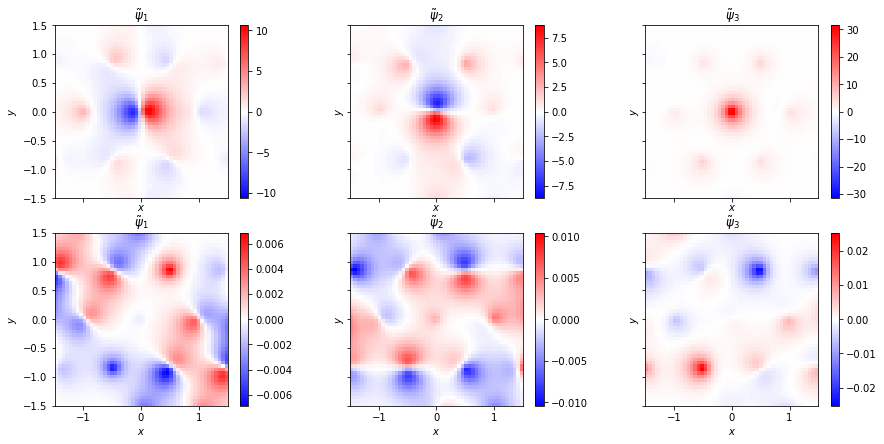

In [5]:
def in_hex(k_x, k_y):
    return (8*np.pi**2 - 2*np.pi*np.abs(k_y) - 4*np.pi*np.abs(k_x)) >= 0

k_x, k_y = np.meshgrid(np.linspace(-np.pi, np.pi, N), np.linspace(-np.pi, np.pi, N))

g_list = [p_x, p_y, s_]
g_norm = [p_norm, p_norm, s_norm]
γ_list = [γ_1, γ_2, γ_3]

R_int = np.zeros((3, 3, len(R_list)))

for i, R in enumerate(R_list):
    for m, γ in enumerate([γ_1, γ_2, γ_3]):
        for n, g in enumerate([p_x, p_y, s]):
            R_int[m, n, i] = np.sum(γ(x_mesh+R[0], y_mesh+R[1])*g(x_mesh, y_mesh)/g_norm[n]) * mesh_tile
        
transform = np.zeros((3, 3, N, N), dtype=complex)

for i in range(N):
    for j in range(N):
        if in_hex(k_y_mesh[i, j], k_x_mesh[i, j]):
            e_list = [np.exp(-1j*(k_x_mesh[i, j]*R[0]+k_y_mesh[i, j]*R[1])) for R in R_list]
            A_k = np.sum(R_int * e_list, axis=2)
            S = np.conj(A_k.T) @ A_k
            eig_val, eig_vec = np.linalg.eigh(S)
            transform[:, :, i, j] = eig_vec.T @ np.diag(1/np.sqrt(eig_val)) @ np.conj(eig_vec) @ A_k

ϕ_list = np.zeros((3, N, N), dtype=complex)

for i in range(N):
    for j in range(N):
        ψ_arr = np.array([ψ(x_mesh[i, j], y_mesh[i, j], k_x_mesh, k_y_mesh, γ) for γ in [γ_1, γ_2, γ_3]])
        ϕ_list[:, i, j] = np.sum(np.swapaxes(transform, 0, 1) * ψ_arr, axis=(1, 2, 3)) * mesh_tile

data =[np.real(ϕ_list), np.imag(ϕ_list)]
max_list = [[np.max(np.abs((data[i][j, :, :]))) for j in range(3)] for i in range(2)]
my_range = [[dict(vmin=-my_max, vmax=my_max, cmap="bwr", extent=[-L,L,-L,L]) for my_max in max_sub_list] for max_sub_list in max_list]

fig, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(15,7))
f_name = [r"$\tilde\psi_1$", r"$\tilde\psi_2$", r"$\tilde\psi_3$"]
for i in range(2):
    for j in range(3):
        im = axes[i, j].imshow(data[i][j, :, :], **(my_range[i][j]))
        axes[i, j].title.set_text(f_name[j])
        axes[i, j].set_xlabel(r"$x$")
        axes[i, j].set_ylabel(r"$y$")
        plt.colorbar(im, ax=axes[i, j], shrink=1)
glue("fig:output_functions", fig, display=False)

```{glue:figure} fig:output_functions
    :name: "three-band-wannier"
   The three Wannierfunctions which resemble the $g_i$: $\tilde\psi_1$ takes after $p_x$, $\tilde\psi_2$ after $p_y$ and $\tilde\psi_3$ after $s$.
```

The three Wannier wavefunctions in {ref}`three-band-wannier` resemble the atomic orbitals chosen for the $g_i$. The $p$ orbitals delocalize to neighboring sites.